## Final Project


### imports and installations

In [4]:
import torch
import torch.nn as nn

import requests
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!pip install transformers | grep -v 'already satisfied'
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from transformers import RobertaTokenizer, RobertaModel, AdamW, XLMRobertaTokenizer, XLMRobertaForSequenceClassification, BertForMaskedLM
from tqdm.auto import tqdm

!pip install --upgrade pip | grep -v 'already satisfied'
!pip install sentencepiece | grep -v 'already satisfied'

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

#Hugging Face new library nlp, to get more NLI datasets than kaggle competition offers
!pip install nlp | grep -v 'already satisfied'
import nlp

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

'grep' is not recognized as an internal or external command,
operable program or batch file.
'grep' is not recognized as an internal or external command,
operable program or batch file.
'grep' is not recognized as an internal or external command,
operable program or batch file.
'grep' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
#define a device we will put our model and our batches on
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
from google.colab import drive #skip the cell if you are not using colab
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Methods for all expirements 

##### Methods to organize the data

In [6]:
def organize_df(df):
  #convert dataset to schema contain two columns
  #first column - premise and hypothesis combined in one sentence ('SEP' between them)
  #second column - the label (0/1/2)

  #Parameters:
  #    df :the dataframe which get converted

  #Returns:
  #    df :the converted dataframe

  df['premise']= df['premise'].str.cat(df['hypothesis'], sep =" [SEP] ")
  df = df.drop(columns=['hypothesis'])
  df = df.rename(columns = {'premise': 'concat_sen'}, inplace = False)

  return df

In [7]:
def clean_data(df):
  #clean wrong labels (only 0/1/2) and duplicates

  #Parameters:
  #    df :the dataframe which get cleaned

  #Returns:
  #    df :the cleaned dataframe


  df = df[df['label'] != -1] # cleaning values with the wrong label
  df = df[df.duplicated() == False] # searching for duplicates
  return df

In [8]:
def prepare_data(data, tokenizer, batch_size=32, roberta_nli=False):
  #convert sentences and labels into token indices

  #Parameters:
  #    data :numpy data contain the sentences and labels
  #    tokenizer :the correct tokenizer for the model that will tranform the data into tokens
  #    batch_size :Unifies the sentences into groups according to the size entered
  #    roberta_nli :swtich between labels 0/2 to meet roberta models format

  #Returns:
  #    data_tokenized :the sentences and labels in tokenized format divided into batches


    data_tokenized = []
    batch_tokenized = []
    batch_labels = []
    count_errors = 0

    #iterate through all sentences in the data
    for i in range (len(data)):

      if i%(batch_size) == 0:
        #iterate through the sentences in the batch
        for j in range(batch_size):
          if (i+j)<len(data): # prevent out of bound
            batch_tokenized.append(data[i+j][0])

            if roberta_nli == True:
              if data[i+j][1] == 0:
                data[i+j][1] = 2
              elif data[i+j][1] == 2:
                data[i+j][1] = 0 

            batch_labels.append(data[i+j][1])
        
        try:
          tokenized_inputs = tokenizer(batch_tokenized, padding=True, return_tensors="pt") #create a tensor for the batch in "tokenized" format

          batch_labels_tensor = torch.LongTensor(batch_labels)
          tokenized_inputs.update({'labels':batch_labels_tensor}) #add labels to tokenized_inputs
          #print(tokenized_inputs)

          data_tokenized.append(tokenized_inputs)

          batch_tokenized = []
          batch_labels = []
        except:
          count_errors+=1

    #print("{} batches were not included since an error occured".format(count_errors))
    return data_tokenized

##### Methods for first option of fine tuning Bert models

In [9]:
def set_parameters(params,layer_freeze):
  #freeze all parameters in layers under some given layer

  #Parameters:
  #    params :the parameters of the model
  #    layer_freeze (int):number of layer
  
  
  layer=0
  for name, param in params:
    if layer<layer_freeze:
      param.requires_grad=False
    
    layer+=1

In [10]:
def train_loop(model, n_epochs, train_data, val_data):
  #train the given model on a given train data

  #Parameters:
  #    model :the model to train
  #    n_epochs :number of epochs
  #    train_data :the data for training
  #    val_data :the data for validation

  #Returns:
  #    plot of losses on the training and validation data

  train_loss_array = []
  val_loss_array = []

  # Loss function
  criterion = nn.CrossEntropyLoss()

  #progress_bar = tqdm(range(num_training_steps))
  model.train()

  for e in range(n_epochs):
    total_loss_train = 0
    total_loss_val = 0
    count_batch_num = 0

    #iterate through all batches in the train data
    for batch in train_data:
      
      optimizer.zero_grad()

      batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model(**batch)

      loss = outputs.loss
      loss.backward()
      
      optimizer.step()

      total_loss_train += loss.item()

      if count_batch_num%500 == 0:
        #print("epoch num {}, batch num {}".format(e, count_batch_num))
        count_batch_num +=1
        
    for batch in val_data:
      optimizer.zero_grad()
      batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model(**batch)
      loss = outputs.loss

      total_loss_val += loss.item()

    #print loss
    print('----------Epoch {}, train loss={}---------'.format(e, total_loss_train/len(train_data)))
    print('----------Epoch {}, val loss={}---------'.format(e, total_loss_val/len(val_data)))
    train_loss_array.append(total_loss_train/len(train_data))
    val_loss_array.append(total_loss_val/len(val_data))

  fig, ax = plt.subplots() 
  ax.plot(train_loss_array, label='Train loss:')  
  ax.plot(val_loss_array, label='Validate loss:')  
  ax.set_xlabel('epoch')  
  ax.set_ylabel('loss')  
  ax.set_title("Train and Validate:")  
  ax.legend()

In [11]:
def evaluate(model, data):
  #evaluate the given model on a given data

  #Parameters:
  #    model :the model to evaluate
  #    data :the data to evaluate on

  #Returns:
  #    precision_list :the precision of each label (0/1/2)  
  #    recall_list :the recall of each label (0/1/2)   
  #    f1_list :the f1 score of each label (0/1/2)  
  #    accuracy :the accuracy of the model

  all_predictions = []
  all_true_labels = []

  precision_list = []
  recall_list = []
  f1_list = []

  model.eval()
  
  for batch in data:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    
    logits = outputs.logits
    
    predictions = torch.argmax(logits, dim=-1)
    prediction_batch = predictions.cpu().numpy()
    
    true_label_batch = batch['labels'].cpu().numpy()
    
    #create one big lists of all batches of the predictions and the true labels
    all_predictions.extend(prediction_batch)
    all_true_labels.extend(true_label_batch)

  #print(all_predictions)
  #print(all_true_labels)

  #calc precision and recall for each class separately
  for i in range(3):
        
    #precision
    class_precision = precision_score(all_true_labels, all_predictions, labels=[i], average='weighted')
    precision_list.append(class_precision)

    #recall
    class_recall = recall_score(all_true_labels, all_predictions, labels=[i], average='weighted')
    recall_list.append(class_recall)

    #f-1
    class_f1 = f1_score(all_true_labels, all_predictions, labels=[i], average='weighted')
    f1_list.append(class_f1)

  #accuracy
  accuracy = accuracy_score(all_true_labels, all_predictions)

  return precision_list, recall_list, f1_list, accuracy

In [12]:
def print_eval(precision_val, recall_val, f1_val, acc):
  #print the evaluation calculated in 'evaluate' method

  print("********Results*********")
  print("The model accuracy is {}".format(acc))
  all_results = [precision_val, recall_val, f1_val]
  columns = [0,1,2]
  indexes = ["precision_val", "recall_val", "f1_val"]
  table = pd.DataFrame(all_results, index = indexes, columns=columns)
  return table

##### class and methods for second option of fine tuning BERT models

In [13]:
class BERT_ft(nn.Module):
    def __init__(self, model_name, num_labels=3, dropout=0.8, classifier_input = '[CLS]'):
      #add 2 fully connected classification layers to the given model and dropout

      #Parameters:
      #    model_name :the model name of the pre-trained transformer
      #    num_labels :number of labels to classify
      #    dropout :dropout value for the model
  
      super(BERT_ft, self).__init__()
      
      #load the pre-trained model and get the last hidden layer size
      if model_name == 'bert-base-uncased' or model_name == 'bert-base-multilingual-cased':
        self.model = BertForSequenceClassification.from_pretrained(model_name, output_hidden_states=True)  
        hidden_size=768
      if model_name == 'xlm-roberta-large':
        self.model = XLMRobertaForSequenceClassification.from_pretrained(model_name, output_hidden_states=True)
        hidden_size=1024
      if model_name == 'roberta-large-mnli':
        self.model = RobertaModel.from_pretrained(model_name,output_hidden_states=True)
        hidden_size=1024
      if model_name == 'microsoft/deberta-v2-xlarge-mnli':
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name ,output_hidden_states=True)
        hidden_size=1536
      
      self.dropout = nn.Dropout(dropout)
      self.relu = nn.ReLU()
 
      #linear layers for classification
      self.fc1 = nn.Linear(hidden_size, 512)
      self.fc2 = nn.Linear(512, num_labels)

      self.classifier_input = classifier_input
    #feedforward neural network
    def forward(self, input,mask):
           
      output = self.model(input,attention_mask = mask, output_hidden_states=True)
      output = output.hidden_states[-1]
      #print(output)
      if self.classifier_input == '[CLS]':
        x = self.fc1(output[:,0,:])
      if self.classifier_input == 'mean':
        x = self.fc1(torch.mean(output, 1))
      
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
 
      return x
    
    #freeze all layers in the pre-trained model
    def freezeAll(self):
      for name, param in self.model.named_parameters():
          param.requires_grad=False
    
    #freeze all parameters in layers under some given layer
    def freezeByLayer(self,layer_freeze=181):
      layer=0
      for name, param in self.model.named_parameters():
        if layer<layer_freeze:
          param.requires_grad=False
        else:
          param.requires_grad=True
 
        layer+=1

In [14]:
def trainBERT_ft(model, optimizer, n_epochs, train_data, val_data, freeze=0, save='no'):
  #train the given model on a given train data with the class 'Bert_ft' 

  #Parameters:
  #    model :the model to train
  #    optimizer :the optimizer to train with
  #    n_epochs :number of epochs
  #    train_data :the data for training
  #    val_data :the data for validation
  #    freeze :decide how many layers to freeze
  #    save :save the model to outside source

  #Returns:
  #    plot of losses on the training and validation data

  #decide how many layers to freeze
  if freeze == 0:
    model.freezeAll()
  else:
    model.freezeByLayer(freeze)
  #181 for layer 11 / 373 for layer 23 - freeze all but the last layer in Bert base / Bert large accordingly
  #165 for layer 10 / 357 for layer 22 - freeze all but the last 2 layers in Bert base / Bert large accordingly

  criterion = nn.CrossEntropyLoss()
  model.train()

  train_loss_array = []
  val_loss_array = []

  for epoch in range(n_epochs):
    total_loss_train = 0
    total_loss_val = 0

    for i, data in enumerate(train_data, 0):
        
      # get the inputs
      inputs = data['input_ids']
      masks = data['attention_mask']
      labels = data['labels']

      inputs = inputs.cuda() # -- For GPU
      masks = masks.cuda() # -- For GPU
      labels = labels.cuda() # -- For GPU

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize

      outputs = model(inputs,masks)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # print statistics

      total_loss_train += loss.item()

      #if i%100==0 and i!=0:
        #print('Epoch {}, Batch {}, batch_loss={}, total_loss={}'.format(epoch,i,loss.item(),total_loss/i))

    for i, data in enumerate(val_data, 0):
      # get the inputs
      inputs = data['input_ids']
      masks = data['attention_mask']
      labels = data['labels']

      inputs = inputs.cuda() # -- For GPU
      masks = masks.cuda() # -- For GPU
      labels = labels.cuda() # -- For GPU

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize

      outputs = model(inputs,masks)
      loss = criterion(outputs, labels)

      # print statistics

      total_loss_val += loss.item()

    if save!='no': 
      save_model(model,epoch,save,total_loss_train)

    print('Epoch {}, loss_train={}'.format(epoch, total_loss_train/len(train_data)))
    print('Epoch {}, loss_eval={}'.format(epoch, total_loss_val/len(val_data)))

    train_loss_array.append(total_loss_train/len(train_data))
    val_loss_array.append(total_loss_val/len(val_data))
 
  print('Finished Training')
  
  fig, ax = plt.subplots() 
  ax.plot(train_loss_array, label='Train loss:')  
  ax.plot(val_loss_array, label='Validation loss:')  
  ax.set_xlabel('epoch')  
  ax.set_ylabel('loss')  
  ax.set_title("Train and Validation:")  
  ax.legend()

In [15]:
def evaluateBERT_ft(model, val_data):
  #evaluate the given model on a given data with the class 'Bert_ft'  

  #Parameters:
  #    model :the model to evaluate
  #    data :the data to evaluate on

  #Returns:
  #    precision_list :the precision of each label (0/1/2)  
  #    recall_list :the recall of each label (0/1/2)   
  #    f1_list :the f1 score of each label (0/1/2)  
  #    accuracy :the accuracy of the model
 
  all_predictions = []
  all_true_labels = []
 
  precision_list = []
  recall_list = []
  f1_list = []

  model.eval()
  with torch.no_grad():
      for data in val_data:
          inputs = data['input_ids']
          masks = data['attention_mask']
          labels = data['labels']
          
 
          inputs = inputs.cuda()  # -- for GPU
          masks = masks.cuda()  # -- for GPU
          labels = labels.cuda()  # -- for GPU
 
          outputs = model(inputs,masks)
          predicted = torch.max(outputs.data, 1)[1]
         
          prediction_batch = predicted.cpu().numpy()
          true_label_batch = labels.cpu().numpy()
          all_predictions.extend(prediction_batch)
          all_true_labels.extend(true_label_batch)
 
  #calc precision and recall for each class separately
  for i in range(3):
        
    #precision
    class_precision = precision_score(all_true_labels, all_predictions, labels=[i], average='weighted')
    precision_list.append(class_precision)
 
    #recall
    class_recall = recall_score(all_true_labels, all_predictions, labels=[i], average='weighted')
    recall_list.append(class_recall)
 
    #f-1
    class_f1 = f1_score(all_true_labels, all_predictions, labels=[i], average='weighted')
    f1_list.append(class_f1)

  #accuracy
  accuracy = accuracy_score(all_true_labels, all_predictions)
 
  return precision_list, recall_list, f1_list, accuracy

##### Methods for test data

In [16]:
def prepare_test_data(data, tokenizer, batch_size=32):
  #convert sentences into token indices

  #Parameters:
  #    data :numpy data which contain the sentences 
  #    tokenizer :the correct tokenizer for the model that will tranform the data into tokens
  #    batch_size :Unifies the sentences into groups according to the size entered

  #Returns:
  #    data_tokenized :the sentences and labels in tokenized format divided into batches

    data_tokenized = []
    batch_tokenized = []

    #iterate through all sentences in the data
    for i in range (len(data)):
      if i%(batch_size) == 0:
        #iterate through the sentences in the batch
        for j in (range(batch_size)):
          if (i+j)<len(data): # prevent out of bound
            batch_tokenized.append(data[i+j][0])

        tokenized_inputs = tokenizer(batch_tokenized, padding=True, return_tensors="pt") #create a tensor for the batch in "tokenized" format

        data_tokenized.append(tokenized_inputs)
        batch_tokenized = []

    return data_tokenized

In [17]:
def predict(model, data, roberta_nli=False):
  #return the prediction for given data

  #Parameters:
  #    model :the model to predict
  #    data :the data to predict on
  #    roberta_nli :swtich between labels 0/2 to meet roberta models format

  #Returns:
  #    all_predictions :1-D array of all predictions

  all_predictions = []

  model.eval()
  
  for batch in data:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits

    predictions = torch.argmax(logits, dim=-1)
    prediction_batch = predictions.cpu().numpy()

    if roberta_nli == True:
      for i in range(len(prediction_batch)):
        if prediction_batch[i] == 0:
          prediction_batch[i] = 2
        elif prediction_batch[i] == 2:
          prediction_batch[i] = 0 

    #create one big lists of all batches of the predictions
    all_predictions.extend(prediction_batch)

  return all_predictions

In [15]:
def predict_Bert_ft(model, data, roberta_nli=False):
  #return the prediction for given data

  #Parameters:
  #    model :the model to predict
  #    data :the data to predict on
  #    roberta_nli :swtich between labels 0/2 to meet roberta models format

  #Returns:
  #    all_predictions :1-D array of all predictions

  all_predictions = []

  model.eval()
  with torch.no_grad():
      for data in data:
        inputs = data['input_ids']
        masks = data['attention_mask']

        inputs = inputs.cuda()  # -- for GPU
        masks = masks.cuda()  # -- for GPU

        outputs = model(inputs,masks)
        predicted = torch.max(outputs.data, 1)[1]
        
        prediction_batch = predicted.cpu().numpy()

        if roberta_nli == True:
          for i in range(len(prediction_batch)):
            if prediction_batch[i] == 0:
              prediction_batch[i] = 2
            elif prediction_batch[i] == 2:
              prediction_batch[i] = 0 
        
        #create one big lists of all batches of the predictions
        all_predictions.extend(prediction_batch)

    #logits = outputs.logits
    #predictions = torch.argmax(logits, dim=-1)
    #prediction_batch = predictions.cpu().numpy()

  return all_predictions

##### Save and load models (checkpoints)

In [18]:
def save_model(model,EPOCH,file_name,LOSS):
  #save the model parameters to external drive

  PATH = '/content/drive/My Drive/Colab Notebooks/NLP final project/saved models/'+file_name+'E'+str(EPOCH)+'.pt'
  torch.save({
              'epoch': EPOCH,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': LOSS,
              }, PATH)

def load_model(model,optimizer,PATH,train=True):
  #load the model parameters from external drive

  checkpoint = torch.load(PATH)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']

  if train:
    model.train()
  else:
    model.eval()

### Kaggle dataset + EDA

Kaggle Contains a training and validation dataset that has 12120 and 5195 text pairs respectively. This dataset contains textual pairs from 15 different languages – Arabic, Bulgarian, Chinese, German, Greek, English, Spanish, French, Hindi, Russian, Swahili, Thai, Turkish, Urdu, and Vietnamese. Sentence pairs are classified into three classes entailment (0), neutral (1), and contradiction (2).

In [20]:
#load train dataset
train_kaggle_df = pd.read_csv("https://raw.githubusercontent.com/orsho/NLI-kaggle-competition-/main/data/kaggle%20train.csv")
print("The training dataset contain {} text pairs".format(len(train_kaggle_df)))
train_kaggle_df.head()

The training dataset contain 12120 text pairs


,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


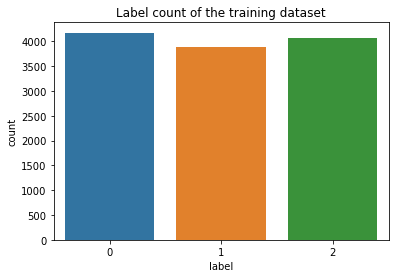

In [22]:
#show label count of the training dataset
plt.title('Label count of the training dataset')
sns.countplot(data = train_kaggle_df, x = 'label')
plt.show()

In [23]:
#load test dataset
test_kaggle_df = pd.read_csv("https://raw.githubusercontent.com/orsho/NLI-kaggle-competition-/main/data/kaggle%20test.csv")
print("The test dataset contain {} text pairs".format(len(test_kaggle_df)))
test_kaggle_df.head()

The test dataset contain 5195 text pairs


,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


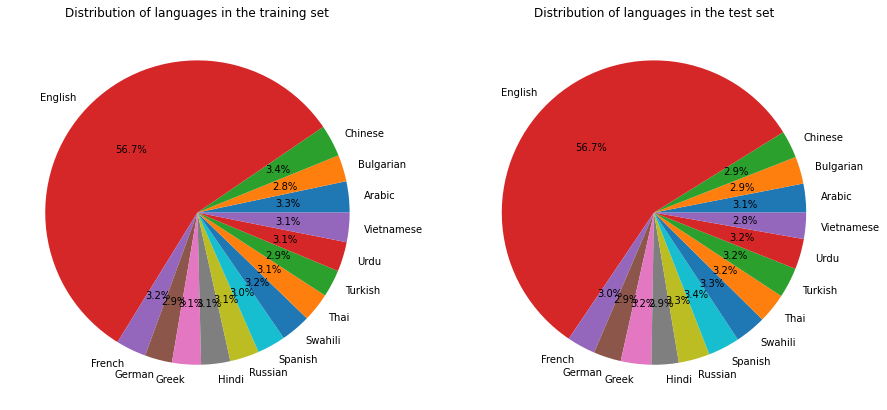

In [20]:
#show distribution of languages in train and test set
labels_train, frequencies_train = np.unique(train_kaggle_df.language.values, return_counts = True)
labels_test, frequencies_test = np.unique(test_kaggle_df.language.values, return_counts = True)

fig = plt.figure(figsize = (15,9))

plt.subplot(1,2,1)
plt.pie(frequencies_train,labels = labels_train, autopct = '%1.1f%%')
plt.title("Distribution of languages in the training set")

plt.subplot(1,2,2)
plt.pie(frequencies_test,labels = labels_test, autopct = '%1.1f%%')
plt.title("Distribution of languages in the test set")

plt.show()

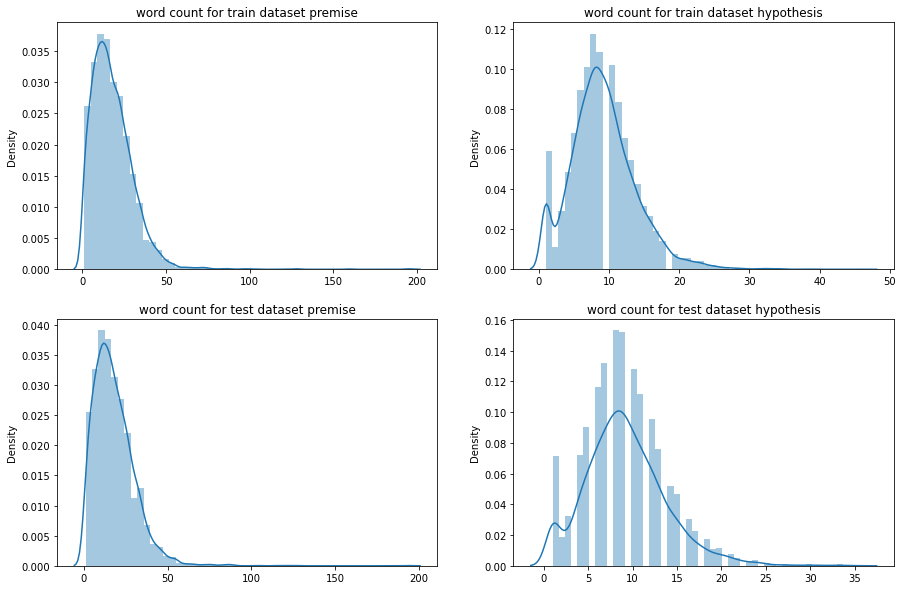

In [24]:
#show word count for train/test dataset hypothesis/premise
def word_count(dataset, column):
    len_vector = []
    for text in dataset[column]:
        len_vector.append(len(text.split()))
    
    return len_vector

train_premise = word_count(train_kaggle_df, 'premise')
train_hypothesis = word_count(train_kaggle_df, 'hypothesis')

# word count

def word_count(dataset, column):
    len_vector = []
    for text in dataset[column]:
        len_vector.append(len(text.split()))
    
    return len_vector

train_premise = word_count(train_kaggle_df, 'premise')
train_hypothesis = word_count(train_kaggle_df, 'hypothesis')

test_premise = word_count(test_kaggle_df, 'premise')
test_hypothesis = word_count(test_kaggle_df, 'hypothesis')

fig = plt.figure(figsize = (15,10))

plt.subplot(2,2,1)
plt.title('word count for train dataset premise')
sns.distplot(train_premise)

plt.subplot(2,2,2)
plt.title('word count for train dataset hypothesis')
sns.distplot(train_hypothesis)

plt.subplot(2,2,3)
plt.title('word count for test dataset premise')
sns.distplot(test_premise)

plt.subplot(2,2,4)
plt.title('word count for test dataset hypothesis')
sns.distplot(test_hypothesis) 

plt.show()


### More NLI datasets

##### Load MNLI dataset

1. The Multi-Genre Natural Language Inference (MultiNLI) corpus is a crowd-sourced collection of 433k sentence pairs annotated with textual entailment information.
2. The MultiNLI dataset comes with three subsets: train, dev_matched, dev_mismatched. The dev_matched dataset are from the same genres as the train dataset, while the dev_mismatched dataset are from genres not seen in the training dataset
3. The dataset contains samples in English only

In [25]:
mnli = nlp.load_dataset('multi_nli')

#exploring the data
print('The number of training examples in mnli dataset:', mnli['train'].num_rows)
print('The number of validation examples in mnli dataset - part 1:', mnli['validation_matched'].num_rows)
print('The number of validation examples in mnli dataset - part 2:', mnli['validation_mismatched'].num_rows, '\n')

print('The class names in mnli dataset:', mnli['train'].features['label'].names)
print('The feature names in mnli dataset:', list(mnli['train'].features.keys()), '\n')

OSError: [Errno 22] Invalid argument: 'C:\\Users\\Or Shoham\\.cache\\huggingface\\datasets\\downloads\\extracted\\5a93e08d090dc52c7a3d14080e1c1853859ef289758ac2d9ad6035f2647ce4fc\\multinli_1.0\\Icon\r'

##### Load SNLI dataset

1. The Stanford Natural Language Inference (SNLI) corpus is a collection of 570k human-written English sentence pairs manually labeled for balanced classification with the labels entailment, contradiction, and neutral

In [18]:
snli = nlp.load_dataset('snli')

#exploring the data
print('The number of training examples in snli dataset:', snli['train'].num_rows)
print('The number of validation examples in snli dataset:', snli['validation'].num_rows, '\n')

print('The class names in snli dataset:', snli['train'].features['label'].names)
print('The feature names in snli dataset:', list(snli['train'].features.keys()), '\n')

The number of training examples in snli dataset: 550152
The number of validation examples in snli dataset: 10000 

The class names in snli dataset: ['entailment', 'neutral', 'contradiction']
The feature names in snli dataset: ['premise', 'hypothesis', 'label'] 



##### Load XNLI dataset

1. The Cross-lingual Natural Language Inference (XNLI) corpus is a crowd-sourced collection of 5,000 test and 2,500 dev pairs for the MultiNLI corpus
2. The pairs are annotated with textual entailment and translated into 14 languages. This results in 112.5k annotated pairs
3. The corpus is made to evaluate how to perform inference in any language when only English NLI data is available at training time


In [19]:
#load dev xnli
filename_dev = 'https://raw.githubusercontent.com/orsho/NLI-kaggle-competition-/main/data/xnli.dev.tsv'
df_dev = pd.read_csv(filename_dev, delimiter='\t')

#load test xnli part1
filename_test1 = 'https://raw.githubusercontent.com/orsho/NLI-kaggle-competition-/main/data/xnli_test_part1.xlsx'
df_test1 = pd.read_excel(filename_test1)

#load test xnli part2
filename_test2 = 'https://raw.githubusercontent.com/orsho/NLI-kaggle-competition-/main/data/xnli_test_part2.xlsx'
df_test2 = pd.read_excel(filename_test2)

#concat all df together
train_xnli_df = pd.concat([df_dev, df_test1, df_test2], axis=0)
print("size of xnli data = {}".format(len(train_xnli_df)))
train_xnli_df.head()

size of xnli data = 112500


,language,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,promptID,pairID,genre,label1,label2,label3,label4,label5,sentence1_tokenized,sentence2_tokenized,match
0,ar,neutral,NaN,NaN,NaN,NaN,وقال، ماما، لقد عدت للمنزل.,اتصل بأمه حالما أوصلته حافلة المدرسية.,1,1,facetoface,neutral,contradiction,neutral,neutral,neutral,وقال ، ماما ، لقد عدت للمنزل .,اتصل بأمه حالما أوصلته حافلة المدرسية .,True
1,ar,contradiction,NaN,NaN,NaN,NaN,وقال، ماما، لقد عدت للمنزل.,لم ينطق ببنت شفة.,1,2,facetoface,contradiction,contradiction,contradiction,contradiction,contradiction,وقال ، ماما ، لقد عدت للمنزل .,لم ينطق ببنت شفة .,True
2,ar,entailment,NaN,NaN,NaN,NaN,وقال، ماما، لقد عدت للمنزل.,أخبر أمه أنه قد عاد للمنزل.,1,3,facetoface,entailment,entailment,neutral,entailment,entailment,وقال ، ماما ، لقد عدت للمنزل .,أخبر أمه أنه قد عاد للمنزل .,True
3,ar,neutral,NaN,NaN,NaN,NaN,لم أعرف من أجل ماذا أنا ذاهب أو أي شىْ ، لذلك ...,لم أذهب إلى واشنطن من قبل، لذا عندما تم تكليفي...,6,16,facetoface,neutral,neutral,neutral,neutral,neutral,لم أعرف من أجل ماذا أنا ذاهب أو أي شىْ ، لذلك ...,لم أذهب إلى واشنطن من قبل ، لذا عندما تم تكليف...,True
4,ar,contradiction,NaN,NaN,NaN,NaN,لم أعرف من أجل ماذا أنا ذاهب أو أي شىْ ، لذلك ...,لقد عرفت بالضبط ما الذي احتجت أن أفعله عندما م...,6,17,facetoface,contradiction,contradiction,contradiction,contradiction,contradiction,لم أعرف من أجل ماذا أنا ذاهب أو أي شىْ ، لذلك ...,لقد عرفت بالضبط ما الذي احتجت أن أفعله عندما م...,True


In [20]:
def organize_xnli_files(df):
  #convert xnli dataset to schema contain two columns
  #first column - premise and hypothesis combined in one sentence ('SEP' between them)
  #second column - the label (0/1/2)

  #Parameters:
  #    df :the dataframe which get converted

  #Returns:
  #    df :the converted dataframe

  df['sentence1']= df['sentence1'].str.cat(df['sentence2'], sep =" [SEP] ")
  df = df.drop(columns=['language', 'sentence1_binary_parse', 'sentence2_binary_parse', 'sentence1_parse', 'sentence2_parse', \
                      'promptID', 'pairID', 'genre', 'label1', 'label2', 'label3', 'label4', 'label5', 'sentence1_tokenized', \
                      'sentence2_tokenized', 'match' , 'sentence2'])
  df = df.rename(columns = {'sentence1': 'concat_sen', 'gold_label': 'label'}, inplace = False)
  df["label"].replace({"entailment": 0, "neutral": 1, "contradiction": 2}, inplace=True)
  
  return df

### Organize all datasets for expirements

##### Organize Kaggle data

In [21]:
#convert kaggle dataset to the desired format (two columns - the two sentences combined and the label)
train_df_after_drop = train_kaggle_df.drop(columns=['id', 'lang_abv', 'language'])
train_df_after_drop = organize_df(train_df_after_drop)
train_df_after_drop.sample(frac=1, random_state=12)

#split to train and validation set
train_kaggle_df = train_df_after_drop[2400:]
val_kaggle_df = train_df_after_drop[0:2400]

##### Organize all other datasets

In [22]:
# Unified MNLI train dataset to desired dataframe schema
train_mnli_df = pd.DataFrame({'premise' : mnli['train']['premise'], 'hypothesis' : mnli['train']['hypothesis'], 'label' : mnli['train']['label']})
train_mnli_df = organize_df(train_mnli_df)
train_mnli_df.sample(frac=1, random_state=12)
train_mnli_df = clean_data(train_mnli_df)

# Unified SNLI train dataset to desired dataframe schema
train_snli_df = pd.DataFrame({'premise' : snli['train']['premise'], 'hypothesis' : snli['train']['hypothesis'], 'label' : snli['train']['label']})
train_snli_df = organize_df(train_snli_df)
train_snli_df.sample(frac=1, random_state=12)
train_snli_df = clean_data(train_snli_df)


# Unified XNLI train dataset to desired dataframe schema
train_xnli_df = organize_xnli_files(train_xnli_df)
train_xnli_df.sample(frac=1, random_state=12)
train_xnli_df = clean_data(train_xnli_df)


##### concat all datasets together

In [23]:
#concat and summuraize all the data for next expirements
print("size of kaggle train data = {}".format(len(train_kaggle_df)))
print("size of mnli train data = {}".format(len(train_mnli_df)))
print("size of snli train data = {}".format(len(train_snli_df)))
print("size of xnli train data = {}".format(len(train_xnli_df)))

all_train_df = pd.concat([train_kaggle_df, train_mnli_df, train_snli_df, train_xnli_df], axis=0)
train_kaggle_mnli_xnli = pd.concat([train_kaggle_df,train_mnli_df, train_xnli_df], axis=0)
print("size of all train data together = {}".format(len(all_train_df)))
print("size of all train data except snli = {}".format(len(train_kaggle_mnli_xnli)))
print("size of validation data = {}".format(len(val_kaggle_df)))

size of kaggle train data = 9720
size of mnli train data = 392680
size of snli train data = 548820
size of xnli train data = 112493
size of all train data together = 1063713
size of all train data except snli = 514893
size of validation data = 2400


### Experiment 1

naive approach in order to better understand the data and the task we are dealing with

##### Prepare the data and tokenize 


In [31]:
#for the first experiment we chose 'bert-base-multilingual-cased'
#pretrained model of the top 104 languages with the largest Wikipedia - didn;t train specific for NLI purposes 
model_name = 'bert-base-multilingual-cased' 
tokenizer = BertTokenizer.from_pretrained(model_name)

#convert to numpy
train_kaggle = train_kaggle_df.to_numpy()
val_kaggle = val_kaggle_df.to_numpy()

#convert the data into tokenize format
train_tokenized = prepare_data(train_kaggle, tokenizer, batch_size=32)
val_tokenized = prepare_data(val_kaggle, tokenizer)

In [32]:
#verify the batches in the right format
for batch in train_tokenized:
    break
{k: v.shape for k, v in batch.items()}

{'attention_mask': torch.Size([32, 118]),
 'input_ids': torch.Size([32, 118]),
 'labels': torch.Size([32]),
 'token_type_ids': torch.Size([32, 118])}

##### Set model parameters and train

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

----------Epoch 0, train loss=1.0509268963023235---------
----------Epoch 0, val loss=1.0195870701471965---------
----------Epoch 1, train loss=0.9535707760798303---------
----------Epoch 1, val loss=0.9788087836901347---------
----------Epoch 2, train loss=0.8878098191007188---------
----------Epoch 2, val loss=0.988372220993042---------
----------Epoch 3, train loss=0.8298594047756571---------
----------Epoch 3, val loss=1.0187284429868062---------
----------Epoch 4, train loss=0.7651605961942359---------
----------Epoch 4, val loss=1.0670499229431152---------


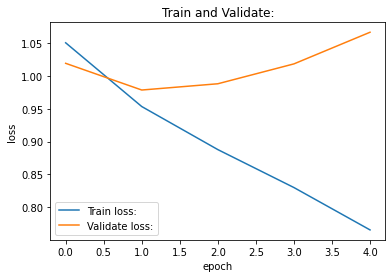

In [33]:
#load the pre-trained model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels = 3)

set_parameters(model.named_parameters(), 181) # fine-tuning only the last layer

model.to(device)

n_epochs = 5
lr=1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=lr) #set an Adam optimizer with learning rate

train_loop(model, n_epochs, train_tokenized, val_tokenized) #train the model 

##### Evaluate model

In [34]:
precision_val, recall_val, f1_val, acc = evaluate(model, val_tokenized)
print_eval(precision_val, recall_val, f1_val, acc)

********Results*********
The model accuracy is 0.5495833333333333


,0,1,2
precision_val,0.550588,0.535802,0.563514
recall_val,0.572127,0.545912,0.529860
f1_val,0.561151,0.540810,0.546169


### Experiment 2

Adding regularization and another way of fine-tuning to reduce early over-fitting

##### Tokenize kaggle data

In [ ]:
#same model as experiment 1
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

train_kaggle = train_kaggle_df.to_numpy()
val_kaggle = val_kaggle_df.to_numpy()

train_tokenized = prepare_data(train_kaggle, tokenizer)
val_tokenized = prepare_data(val_kaggle, tokenizer)

##### Build model and train

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Epoch 0, loss_train=1.086916534328147
Epoch 0, loss_eval=1.0564739076296488
Epoch 1, loss_train=0.9980954308258859
Epoch 1, loss_eval=1.0036153149604798
Epoch 2, loss_train=0.9369672770170789
Epoch 2, loss_eval=0.9936124753952026
Epoch 3, loss_train=0.8910388634785226
Epoch 3, loss_eval=0.9805555121103923
Epoch 4, loss_train=0.8509259318050585
Epoch 4, loss_eval=1.0000786622365316
Finished Training


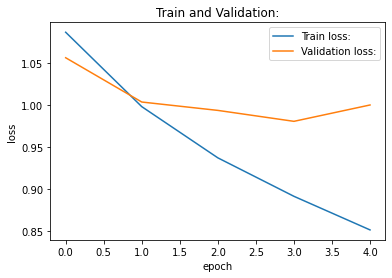

In [ ]:
#fine-tuning model using kaggle data

#choose the best dropout for the model
#dropout = 0.1
#dropout = 0.4
dropout = 0.8

#create the model with adding to more fc layers and dropout
model_ft = BERT_ft(model_name, dropout=dropout).cuda()
 
n_epochs = 5
lr=1e-4
layers_to_freeze = 181 # freeze all but the last layer

optimizer = AdamW(model_ft.parameters(), lr)

trainBERT_ft(model_ft, optimizer, n_epochs, train_tokenized, val_tokenized, freeze=layers_to_freeze)

#####Evaluate model

In [ ]:
precision_val, recall_val, f1_val, acc = evaluateBERT_ft(model_ft, val_tokenized)
print_eval(precision_val, recall_val, f1_val, acc)

********Results*********
The model accuracy is 0.5704166666666667


,0,1,2
precision_val,0.559211,0.567968,0.586577
recall_val,0.623472,0.530818,0.555273
f1_val,0.589595,0.548765,0.570496


### Experiment 3 

Adding more data to the training process

##### Prepare the data and tokenize 


In [21]:
#same model as experiment 1 and 2
model_name = 'bert-base-multilingual-cased' 
tokenizer = BertTokenizer.from_pretrained(model_name)

#used only mnli and xnli since snli didn't help to improve accuracy
train_kaggle_mnli_xnli_numpy = train_kaggle_mnli_xnli.to_numpy()
val_kaggle = val_kaggle_df.to_numpy()

train_kaggle_mnli_xnli_tokenized = prepare_data(train_kaggle_mnli_xnli_numpy, tokenizer)
val_kaggle_tokenized = prepare_data(val_kaggle, tokenizer)


##### Set model parameters and train

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Epoch 0, loss_train=0.8339451954318388
Epoch 0, loss_eval=0.8286500636736552
Epoch 1, loss_train=0.7338591298923237
Epoch 1, loss_eval=0.7986508671442668
Epoch 2, loss_train=0.6913488080249157
Epoch 2, loss_eval=0.7582783591747284
Epoch 3, loss_train=0.6589221934654668
Epoch 3, loss_eval=0.7511963812510173
Epoch 4, loss_train=0.6324380861232609
Epoch 4, loss_eval=0.7629752723375957
Finished Training


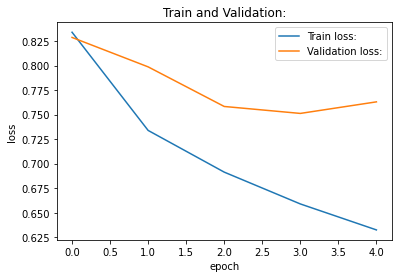

In [22]:
model_ft = BERT_ft(model_name).to(device)
 
n_epochs = 5
lr=1e-5
layers_to_freeze = 149 # freeze all but the 2 last layers

optimizer = AdamW(model_ft.parameters(), lr)

trainBERT_ft(model_ft, optimizer, n_epochs, train_kaggle_mnli_xnli_tokenized, val_kaggle_tokenized, freeze=layers_to_freeze)

##### Evaluate model

In [23]:
precision_val, recall_val, f1_val, acc = evaluateBERT_ft(model_ft, val_kaggle_tokenized)
print_eval(precision_val, recall_val, f1_val, acc)
  


********Results*********
The model accuracy is 0.7133333333333334


,0,1,2
precision_val,0.658342,0.705210,0.813725
recall_val,0.805623,0.698113,0.632783
f1_val,0.724574,0.701643,0.711937


In [ ]:
"""
model = BertForSequenceClassification.from_pretrained(model_name, num_labels = 3).to(device)

n_epochs = 5
lr=1e-4
layers_to_freeze = 149 # freeze all but the 2 last layeres

set_parameters(model.named_parameters(), 149)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, eps = 1e-8)

train_loop(model, n_epochs, train_kaggle_mnli_xnli_tokenized, val_kaggle_tokenized)
"""

### Experiment 4

Several different experiments that try to improve the model's performances

#####Tokenize data

In [ ]:
model_name = 'xlm-roberta-large'

tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)
train = train_kaggle_mnli_xnli.to_numpy()
val_kaggle = val_kaggle_df.to_numpy()
val_kaggle = val_kaggle_english_df.to_numpy()
train_tokenized = prepare_data(train, tokenizer)
val_tokenized = prepare_data(val_kaggle, tokenizer)


#####Experiment 4.1 - XLMroberta with maximum data

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.den

Epoch 0, loss_train=0.7003142671238537
Epoch 0, loss_eval=0.6750284957885743
Epoch 1, loss_train=0.5585444562163301
Epoch 1, loss_eval=0.6610916650295258
Epoch 2, loss_train=0.510702429998426
Epoch 2, loss_eval=0.5821885528167089
Epoch 3, loss_train=0.47807502301746835
Epoch 3, loss_eval=0.6072693904240926
Finished Training


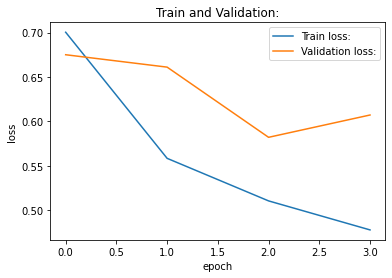

In [ ]:
#find tune model using original data
model_XLM = BERT_ft(model_name).cuda()
 
n_epochs = 4
lr=1e-4
optimizer = AdamW(model_XLM.parameters(), lr)
trainBERT_ft(model_XLM, optimizer, n_epochs, train_tokenized, val_tokenized,freeze=357)

#####Evaluation Ex. 4.1

In [ ]:
precision_val, recall_val, f1_val, acc = evaluateBERT_ft(model_XLM, val_tokenized)
print_eval(precision_val, recall_val, f1_val, acc)

********Results*********
The model accuracy is 0.825


,0,1,2
precision_val,0.795806,0.844702,0.840994
recall_val,0.881418,0.732075,0.860229
f1_val,0.836427,0.784367,0.850503


In [ ]:
save_model(model_XLM,4,'XLMrobertaFullData',0.001)

#####Experiment 4.2 - using mean of hidden vectors

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.den

Epoch 0, loss_train=0.6736881561127326
Epoch 0, loss_eval=0.671314288576444
Epoch 1, loss_train=0.5565936640982144
Epoch 1, loss_eval=0.6459895567099253
Epoch 2, loss_train=0.5141546036703307
Epoch 2, loss_eval=0.5985287541151046
Epoch 3, loss_train=0.48726635106832067
Epoch 3, loss_eval=0.5704005322853725
Finished Training


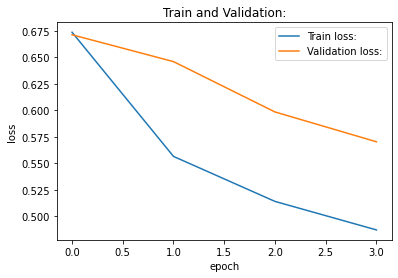

In [ ]:


#find tune model using original data
model_XLM_mean = BERT_ft(model_name, classifier_input='mean').cuda()
n_epochs = 4
lr=1e-4
layers_to_freeze = 357 # freeze all but the last two layers
optimizer = AdamW(model_XLM_mean.parameters(), lr)
trainBERT_ft(model_XLM_mean, optimizer, n_epochs, train_tokenized, val_tokenized,freeze=layers_to_freeze)

#####Evaluation Ex. 4.2

In [ ]:
precision_val, recall_val, f1_val, acc = evaluateBERT_ft(model_XLM_mean, val_tokenized)
print_eval(precision_val, recall_val, f1_val, acc)

********Results*********
The model accuracy is 0.8145833333333333


,0,1,2
precision_val,0.790929,0.829446,0.828395
recall_val,0.874083,0.715723,0.852605
f1_val,0.830430,0.768400,0.840326


In [ ]:
save_model(model_XLM_mean,4,'XLMrobertaMean',0.001)

#####Experiment 4.3 - binary classifier for the worst 2 labels

######Creating binary data

In [ ]:
#create data for two labels
model_name = 'xlm-roberta-large'

tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)
train_binary_df = train_kaggle_mnli_xnli.copy()
train_binary_df = train_binary_df[train_binary_df.label != 2]
train_binary = train_binary_df.to_numpy()

val_kaggle_binary_df = val_kaggle_df.copy()
val_kaggle_binary_df = val_kaggle_binary_df[val_kaggle_binary_df.label != 2]
val_kaggle_binary = val_kaggle_binary_df.to_numpy()

train_binary_tokenized = prepare_data(train_binary, tokenizer)
val_binary_tokenized = prepare_data(val_kaggle_binary, tokenizer)

######training binary model

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.out

Epoch 0, loss_train=0.44421590094530944
Epoch 0, loss_eval=0.5497781914823195
Epoch 1, loss_train=0.3678863286621679
Epoch 1, loss_eval=0.47693705091289446
Epoch 2, loss_train=0.3405213670674275
Epoch 2, loss_eval=0.3917478436932844
Epoch 3, loss_train=0.31886043513215057
Epoch 3, loss_eval=0.4072446411146837
Finished Training


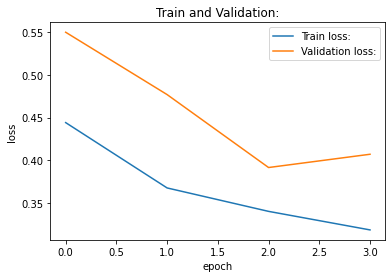

In [ ]:
#train model for two labels
model_XLM_binary = BERT_ft(model_name, num_labels=2).cuda()
n_epochs = 4
lr=1e-4
layers_to_freeze = 357
optimizer = AdamW(model_XLM_binary.parameters(), lr)
trainBERT_ft(model_XLM_binary, optimizer, n_epochs, train_binary_tokenized, val_binary_tokenized,freeze=layers_to_freeze)

######Evaluating binary classifier

In [ ]:
#evaluating binary calssifier
precision_val, recall_val, f1_val, acc = evaluateBERT_ft(model_XLM_binary, val_binary_tokenized)
print_eval(precision_val, recall_val, f1_val, acc)

********Results*********
The model accuracy is 0.8648481091134532


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


,0,1,2
precision_val,0.832594,0.905767,0.0
recall_val,0.918093,0.810063,0.0
f1_val,0.873256,0.855246,0.0


In [ ]:
#load saved model
lr=1e-4
model_XLM = BERT_ft(model_name).cuda()
optimizer = AdamW(model_XLM.parameters(), lr)
PATH = '/content/drive/My Drive/Colab Notebooks/NLP final project/saved models/XLMrobertaFullDataE4.pt'
load_model(model_XLM,optimizer,PATH,train=False)

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.out

#####Evaluation Ex. 4.3

In [ ]:
#evaluating using binary classifier
def evaluateAdvance(model, test_sequences):
  all_predictions = []
  all_true_labels = []
 
  precision_list = []
  recall_list = []
  f1_list = []

  model.eval()
  with torch.no_grad():
      for data in test_sequences:
          inputs = data['input_ids']
          masks = data['attention_mask']
          labels = data['labels']
          
 
          inputs = inputs.cuda()  # -- for GPU
          masks = masks.cuda()  # -- for GPU
          labels = labels.cuda()  # -- for GPU
 
          outputs = model(inputs,masks)
          
          predicted = torch.max(outputs.data, 1)[1]

          for i in range(predicted.shape[0]):
            if predicted[i]!=2:
              inputs = data['input_ids'][i,:].view(1,-1)
              masks = data['attention_mask'][i,:].view(1,-1)
              inputs = inputs.cuda()  # -- for GPU
              masks = masks.cuda()  # -- for GPU
              output = model_XLM_binary(inputs,masks)
              predicted[i] = torch.max(output.data, 1)[1]
         
          prediction_batch = predicted.cpu().numpy()
          true_label_batch = labels.cpu().numpy()
          all_predictions.extend(prediction_batch)
          all_true_labels.extend(true_label_batch)
 
  #calc precision and recall for each class separately
  for i in range(3):
        
    #precision
    class_precision = precision_score(all_true_labels, all_predictions, labels=[i], average='weighted')
    precision_list.append(class_precision)
 
    #recall
    class_recall = recall_score(all_true_labels, all_predictions, labels=[i], average='weighted')
    recall_list.append(class_recall)
 
    #f-1
    class_f1 = f1_score(all_true_labels, all_predictions, labels=[i], average='weighted')
    f1_list.append(class_f1)

  #accuracy
  accuracy = accuracy_score(all_true_labels, all_predictions)
 
  return precision_list, recall_list, f1_list, accuracy

In [ ]:
precision_val, recall_val, f1_val, acc = evaluateAdvance(model_XLM, val_tokenized)
print_eval(precision_val, recall_val, f1_val, acc)

********Results*********
The model accuracy is 0.8204166666666667


,0,1,2
precision_val,0.783784,0.846269,0.840994
recall_val,0.886308,0.713208,0.860229
f1_val,0.831899,0.774061,0.850503


#####Experiment 4.4 - Reduction to MaskedLM model

######Methods for Ex.4.4

In [ ]:
def prepare_data_Mask(data, tokenizer, batch_size=32):
    data_sequences = []
    batch_sequences = []
    batch_labels = []
    count=0
 
    #iterate through all sentences in the data
    for i in range (len(data)):
        if (i+1)%(batch_size) == 0:
            #iterate through the sentences in the batch
            for j in range(batch_size):
                batch_sequences.append(data[i-j][0])
            
            try:
              tokenized_inputs = tokenizer(batch_sequences, padding=True, return_tensors="pt") #create a tensor for the batch in "tokenized" format
              
              index_col = np.sum(tokenized_inputs['attention_mask'].numpy(),axis=1)-2
              index_row=np.array(range(batch_size))
              
              tokenized_labels = tokenized_inputs['input_ids'].detach().clone() #create a tensor for the labels batch in "tokenized" format
              tokenized_inputs['input_ids'][index_row,index_col] = 103              
              tokenized_inputs.update({'labels':tokenized_labels}) #add labels to tokenized_inputs
              #print(tokenized_inputs)
 
              data_sequences.append(tokenized_inputs)
            except:
              print('problematic instance')
            batch_sequences = []
            batch_labels = []
 
    return data_sequences


def evaluate_Mask(model, data):
  #evaluate the given model on a given data

  #Parameters:
  #    model :the model to evaluate
  #    data :the data to evaluate on

  #Returns:
  #    precision_list :the precision of each label (0/1/2)  
  #    recall_list :the recall of each label (0/1/2)   
  #    f1_list :the f1 score of each label (0/1/2)  
  #    accuracy :the accuracy of the model

  all_predictions = []
  all_true_labels = []

  precision_list = []
  recall_list = []
  f1_list = []

  model.eval()
  
  for batch in data:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    
    logits = outputs.logits
    
    predictions = torch.argmax(logits, dim=-1)
    index_col = np.sum(batch['attention_mask'].cpu().numpy(),axis=1)-2
    index_row=np.array(range(batch['attention_mask'].cpu().shape[0]))
    prediction_batch = predictions.cpu().numpy()[index_row,index_col]
    #2765,  8699, 26917
    prediction_batch[prediction_batch==2765] = 0
    prediction_batch[prediction_batch==8699] = 1
    prediction_batch[prediction_batch==26917] = 2
    
    true_label_batch = batch['labels'].cpu().numpy()[index_row,index_col]
    true_label_batch[true_label_batch==2765] = 0
    true_label_batch[true_label_batch==8699] = 1
    true_label_batch[true_label_batch==26917] = 2
    
    #create one big lists of all batches of the predictions and the true labels
    all_predictions.extend(prediction_batch)
    all_true_labels.extend(true_label_batch)

  #print(all_predictions)
  #print(all_true_labels)

  #calc precision and recall for each class separately
  for i in range(3):
        
    #precision
    class_precision = precision_score(all_true_labels, all_predictions, labels=[i], average='weighted')
    precision_list.append(class_precision)

    #recall
    class_recall = recall_score(all_true_labels, all_predictions, labels=[i], average='weighted')
    recall_list.append(class_recall)

    #f-1
    class_f1 = f1_score(all_true_labels, all_predictions, labels=[i], average='weighted')
    f1_list.append(class_f1)

  #accuracy
  accuracy = accuracy_score(all_true_labels, all_predictions)

  return precision_list, recall_list, f1_list, accuracy

######Creating data suited for MaskedLM model

In [ ]:
#Using english data only for train (using mnli) and validation (using kaggle validation)
train_df = train_mnli_df.copy()
train_df['concat_sen'] = train_df['concat_sen'] + ' [SEP] The relation between the two sentnences is'
train_df['concat_sen'][train_df['label']==0] = train_df['concat_sen']+' result' 
train_df['concat_sen'][train_df['label']==1] = train_df['concat_sen']+' neutral' 
train_df['concat_sen'][train_df['label']==2] = train_df['concat_sen']+' contradiction'
train_Mask = train_df.to_numpy()

val_df = val_kaggle_english_df.copy()
val_df['concat_sen'] = val_df['concat_sen'] + ' [SEP] The relation between the two sentnences is'
val_df['concat_sen'][val_df['label']==0] = val_df['concat_sen']+' result' 
val_df['concat_sen'][val_df['label']==1] = val_df['concat_sen']+' neutral' 
val_df['concat_sen'][val_df['label']==2] = val_df['concat_sen']+' contradiction'
val_kaggle_Mask = val_df.to_numpy()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
#tokenize the data using the method prepare_data_Mask
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_tokenized_Mask = prepare_data_Mask(train_Mask, tokenizer)
val_tokenized_Mask = prepare_data_Mask(val_kaggle_Mask, tokenizer)

######Training MaskedLM model

In [ ]:
model_Mask = BertForMaskedLM.from_pretrained('bert-base-uncased').to(device)
set_parameters(model_Mask.named_parameters(), 165)
optimizer = AdamW(model_Mask.parameters(), lr=0.0001)
num_epochs = 4

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


----------Epoch 0, train loss=0.10912122501354236---------
----------Epoch 0, val loss=0.01673951471845309---------
----------Epoch 1, train loss=0.011121450431651596---------
----------Epoch 1, val loss=0.011936784212787946---------
----------Epoch 2, train loss=0.008590381573964991---------
----------Epoch 2, val loss=0.011403023327390353---------
----------Epoch 3, train loss=0.007609461040160767---------
----------Epoch 3, val loss=0.011067294242481391---------


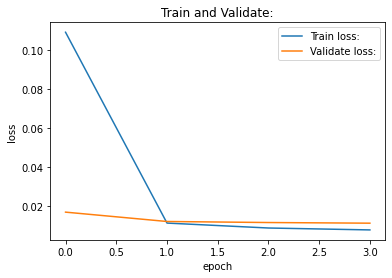

In [ ]:
train_loop(model_Mask, num_epochs, train_tokenized_Mask, val_tokenized_Mask) #train the model

######Evalutaing MaskedLM model

In [ ]:
precision_val, recall_val, f1_val, acc = evaluate_Mask(model_Mask, val_tokenized_Mask)
print_eval(precision_val, recall_val, f1_val, acc)

********Results*********
The model accuracy is 0.7683333333333333


,0,1,2
precision_val,0.798802,0.706918,0.798701
recall_val,0.797847,0.731771,0.772613
f1_val,0.798324,0.719130,0.785441


In [ ]:
save_model(model_Mask,num_epochs,'MLMonMNLIbertBaseUncased',0.001)

#####Evaluation Ex. 4.4

In [ ]:
#load saved model
lr=1e-4
model_Mask = BertForMaskedLM.from_pretrained('bert-base-uncased').to(device)
optimizer = AdamW(model_Mask.parameters(), lr)
PATH = '/content/drive/My Drive/Colab Notebooks/NLP final project/saved models/MLMonMNLIbertBaseUncasedE4.pt'
load_model(model_Mask,optimizer,PATH,train=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import torch.nn.functional as F
#this method predicting the label using the standart evaluation method.
#if the difference between the probability of the chosen label and the second best is small than the threshold -
#then, we will predict this instance using model_MaskLM
def evaluateBERT_Advance2(model, val_data,val_data_Mask, threshold):
  #evaluate the given model on a given data with the class 'Bert_ft'  

  #Parameters:
  #    model :the model to evaluate
  #    data :the data to evaluate on

  #Returns:
  #    precision_list :the precision of each label (0/1/2)  
  #    recall_list :the recall of each label (0/1/2)   
  #    f1_list :the f1 score of each label (0/1/2)  
  #    accuracy :the accuracy of the model
 
  all_predictions = []
  all_true_labels = []
 
  precision_list = []
  recall_list = []
  f1_list = []

  model.eval()
  with torch.no_grad():
      count=0
      count2 = 0
      for i in range(len(val_data)):
          inputs = val_data[i]['input_ids']
          masks = val_data[i]['attention_mask']
          labels = val_data[i]['labels']
          
 
          inputs = inputs.cuda()  # -- for GPU
          masks = masks.cuda()  # -- for GPU
          labels = labels.cuda()  # -- for GPU

          inputs_Mask = val_data_Mask[i]['input_ids']
          masks_Mask = val_data_Mask[i]['attention_mask']
          labels_Mask = val_data_Mask[i]['labels']
          
 
          inputs_Mask = inputs_Mask.cuda()  # -- for GPU
          masks_Mask = masks_Mask.cuda()  # -- for GPU
          labels_Mask = labels_Mask.cuda()  # -- for GPU
          
 
          outputs = model(inputs,masks)
          predicted = torch.max(outputs.data, 1)[1]

          softM_outputs = F.softmax(outputs).cpu().numpy()
          
          for j in range(outputs.shape[0]):
            max = np.argmax(softM_outputs[j]) 
            if abs(softM_outputs[j,max]-softM_outputs[j,(max+1)%3])<threshold or abs(softM_outputs[j,max]-softM_outputs[j,(max+2)%3])<threshold:
              count+=1
              if max==labels[j]:
                count2+=1
              
              outputMask = model_Mask(inputs_Mask[j].view(1,-1), attention_mask=masks_Mask[j].view(1,-1), labels=labels_Mask[j].view(1,-1))
              logits = outputMask.logits
              predictions_Mask = torch.argmax(logits, dim=-1)
              index = np.sum(masks_Mask[j].cpu().numpy())-2
              prediction_label = predictions_Mask.cpu().numpy()[0,index]
              #3672,  8699, 26917
              if prediction_label==2765:
                prediction_label = 0
              elif prediction_label==8699:
                prediction_label = 1
              elif prediction_label==26917:
                prediction_label = 2

             
              predicted[j] = prediction_label

         
          prediction_batch = predicted.cpu().numpy()
          true_label_batch = labels.cpu().numpy()
          all_predictions.extend(prediction_batch)
          all_true_labels.extend(true_label_batch)
  print('The number of instances with predictions close to the second best by ' + str(threshold) +': ' +str(count))
  print('The prediction accuracy is: '+ str(count2/count))

  #calc precision and recall for each class separately
  for i in range(3):
        
    #precision
    class_precision = precision_score(all_true_labels, all_predictions, labels=[i], average='weighted')
    precision_list.append(class_precision)
 
    #recall
    class_recall = recall_score(all_true_labels, all_predictions, labels=[i], average='weighted')
    recall_list.append(class_recall)
 
    #f-1
    class_f1 = f1_score(all_true_labels, all_predictions, labels=[i], average='weighted')
    f1_list.append(class_f1)

  #accuracy
  accuracy = accuracy_score(all_true_labels, all_predictions)
 
  return precision_list, recall_list, f1_list, accuracy

In [ ]:
#prediction using different threshold values
threshold = [0.01,0.05,0.075,0.1,0.2]
for th in threshold:
  print('threshold = ' + str(th))
  precision_val, recall_val, f1_val, acc = evaluateBERT_Advance2(model_XLM, val_tokenized,val_tokenized_Mask,th)
  print_eval(precision_val, recall_val, f1_val, acc)
  print('*********************************************************************************************')

threshold = 0.01


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


The number of instances with predictions close to the second best by 0.01: 7
The prediction accuracy is: 0.2857142857142857
********Results*********
The model accuracy is 0.8079166666666666
*********************************************************************************************
threshold = 0.05
The number of instances with predictions close to the second best by 0.05: 32
The prediction accuracy is: 0.34375
********Results*********
The model accuracy is 0.80625
*********************************************************************************************
threshold = 0.075
The number of instances with predictions close to the second best by 0.075: 47
The prediction accuracy is: 0.425531914893617
********Results*********
The model accuracy is 0.8058333333333333
*********************************************************************************************
threshold = 0.1
The number of instances with predictions close to the second best by 0.1: 57
The prediction accuracy is: 0.4035087719

In [ ]:
#comparing the results to the standart model_XLM from Ex. 4.1 - we can see that maskLM doesn't improve the results.
precision_val, recall_val, f1_val, acc = evaluateBERT_ft(model_XLM, val_tokenized)
print_eval(precision_val, recall_val, f1_val, acc)

********Results*********
The model accuracy is 0.8079166666666666


,0,1,2
precision_val,0.787975,0.835182,0.809988
recall_val,0.893541,0.686198,0.835427
f1_val,0.837444,0.753395,0.822511


### Experiment 5 - best model acheived

1. Divided kaggle data into english sentences and not english sentences
2. used best pre-trained models - "microsoft/deberta-v2-xlarge-mnli" for english sentences and "joeddav/xlm-roberta-large-xnli" for not english sentences
3. for english sentences - trained with mnli+xnli(english only)+kaggle (english only)
4. For other languages sentences - didn't make any train since results gave 98% accuracy

##### Split Kaggle train data into English and other languages

In [24]:
#load Kaggle data and split to English and other languages
train_kaggle_df = pd.read_csv("https://raw.githubusercontent.com/orsho/NLI-kaggle-competition-/main/train.csv")
train_kaggle_english_df = train_kaggle_df[train_kaggle_df.language == 'English']
val_kaggle_other_df = train_kaggle_df[train_kaggle_df.language != 'English'] #all other instances are validation (since we won't do any training)

#convert data to the desired schema
train_kaggle_english_df = train_kaggle_english_df.drop(columns=['id', 'lang_abv', 'language'])
val_kaggle_other_df = val_kaggle_other_df.drop(columns=['id', 'lang_abv', 'language'])
train_kaggle_english_df = organize_df(train_kaggle_english_df)
val_kaggle_other_df = organize_df(val_kaggle_other_df)
train_kaggle_english_df.sample(frac=1, random_state=12)

#split english to train and val
val_kaggle_english_df = train_kaggle_english_df[0:2400]
train_kaggle_english_df = train_kaggle_english_df[2400:]

##### Extract from xnli dataset only english sentences

In [25]:
train_xnli_english_df = pd.concat([df_dev, df_test1, df_test2], axis=0)
train_xnli_english_df = train_xnli_english_df[train_xnli_english_df.language == 'en']
print("size of xnli data = {}".format(len(train_xnli_english_df)))

# Unified english XNLI train dataset to desired dataframe schema
train_xnli_english_df = organize_xnli_files(train_xnli_english_df)
train_xnli_english_df.sample(frac=1, random_state=12)
train_xnli_english_df = clean_data(train_xnli_english_df)

size of xnli data = 7500


##### Concat english data

In [32]:
all_train_english_df = pd.concat([train_kaggle_english_df, train_xnli_english_df], axis=0)
all_train_english_df.sample(frac=1, random_state=12)

,concat_sen,label
10075,"'Not entirely,' I snapped, harsher than intend...",0
7540,The museum is well laid out and the perfect si...,2
21613,I suppose that is after the fashion of your ki...,1
22494,Visitors can also see a 28-minute virtual his...,0
12363,One can also find some definitions here and th...,1
...,...,...
10842,"""Give it to me."" He handed it to her. [SEP] S...",1
20489,He told me what exactly he needed and that he ...,0
10120,New York Times columnist Bob Herbert asserts t...,1
22686,Mercury emissions contribute to mercury deposi...,1


##### Tokenize train and val data

In [33]:
#other models we tried
"""
model_name_english = 'roberta-large-mnli' #pre-trained on NLI english sentences
model_name_english = 'sentence-transformers/nli-bert-base-max-pooling'
model_name_other = 'joeddav/xlm-roberta-large-xnli'
"""

model_name_english = 'microsoft/deberta-v2-xlarge-mnli' #the chosen model for english sentences
tokenizer_english = AutoTokenizer.from_pretrained(model_name_english)

model_name_other = 'joeddav/xlm-roberta-large-xnli' #pre-trained on NLI multilingual sentences
tokenizer_other = AutoTokenizer.from_pretrained(model_name_other)

#convert to numpy
all_train_english = all_train_english_df.to_numpy()
val_kaggle_english = val_kaggle_english_df.to_numpy()
val_kaggle_other = val_kaggle_other_df.to_numpy()

#tokenize data
all_train_english_tokenized = prepare_data(all_train_english, tokenizer_english, roberta_nli=True)
val_kaggle_english_tokenized = prepare_data(val_kaggle_english, tokenizer_english, roberta_nli=True)
val_kaggle_other_tokenized = prepare_data(val_kaggle_other, tokenizer_other, roberta_nli=True)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


##### Load test data

In [28]:
test_df = pd.read_csv("https://raw.githubusercontent.com/orsho/NLI-kaggle-competition-/main/test.csv")
test_df.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


##### Split test data into English and other languages

In [29]:
test_df['premise']= test_df['premise'].str.cat(test_df['hypothesis'], sep =" [SEP] ")
test_df = test_df.rename(columns = {'premise': 'concat_sen'}, inplace = False)

test_kaggle_english_df = test_df[test_df.language == 'English']
test_kaggle_other_df = test_df[test_df.language != 'English']

#get test ids (we will use it for the submission)
test_english_ids = test_kaggle_english_df.id
test_other_ids = test_kaggle_other_df.id

test_kaggle_english_df = test_kaggle_english_df.drop(columns=['id', 'hypothesis','lang_abv','language'])
test_kaggle_other_df = test_kaggle_other_df.drop(columns=['id', 'hypothesis','lang_abv','language'])

##### Tokenized the test data

In [30]:
test_kaggle_english = test_kaggle_english_df.to_numpy()
test_kaggle_other = test_kaggle_other_df.to_numpy()

test_kaggle_english_tokenized = prepare_test_data(test_kaggle_english, tokenizer_english)
test_kaggle_other_tokenized = prepare_test_data(test_kaggle_other, tokenizer_other)


##### Predict English sentences

Epoch 0, loss_train=0.3999527575969696
Epoch 0, loss_eval=0.27244943459828697
Epoch 1, loss_train=0.25719607750574747
Epoch 1, loss_eval=0.27089018325010933
Epoch 2, loss_train=0.24942447609702745
Epoch 2, loss_eval=0.2562108318010966
Epoch 3, loss_train=0.2512338841756185
Epoch 3, loss_eval=0.2623297925790151
Finished Training


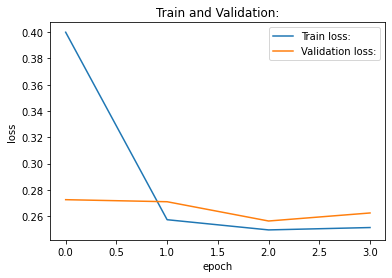

In [34]:
model_english = BERT_ft(model_name_english).to(device)
 
n_epochs = 4
lr=1e-5
layers_to_freeze = 0 # freeze all layers but the 2 fc layers we added

optimizer = AdamW(model_english.parameters(), lr)
trainBERT_ft(model_english, optimizer, n_epochs, all_train_english_tokenized, val_kaggle_english_tokenized, freeze=layers_to_freeze)

predictions_english = predict_Bert_ft(model_english, test_kaggle_english_tokenized, roberta_nli=True) #predict for test english data


##### Evaluation English

In [35]:
precision_val_english, recall_val_english, f1_val_english, acc_english = evaluateBERT_ft(model_english, val_kaggle_english_tokenized)
print_eval(precision_val_english, recall_val_english, f1_val_english, acc_english)

********Results*********
The model accuracy is 0.9191666666666667


,0,1,2
precision_val,0.943890,0.893617,0.918440
recall_val,0.951005,0.875000,0.929426
f1_val,0.947434,0.884211,0.923900


##### Predict other languages sentences

In [36]:
model_other = AutoModelForSequenceClassification.from_pretrained(model_name_other).to(device) #for "joeddav/xlm-roberta-large-xnli"

#decided not to train the sentences which are not in English since we got great result (above 97.6%) without that training 
""" 
#set_parameters(model_other.named_parameters(), 341) # backprop of the only last 2 layer 
set_parameters(model_other.named_parameters(), 373) # backprop of the only last layer 
optimizer = torch.optim.Adam(model_other.parameters(), lr=0.0001, eps = 1e-8)
train_loop(model_other, 5, train_all_tokenized, val_kaggle_tokenized) #train the model 
"""

predictions_other = predict(model_other, test_kaggle_other_tokenized, roberta_nli=True) #predict for test other languages data

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


##### Evaluation other languages

In [37]:
precision_val_other, recall_val_other, f1_val_other, acc_other = evaluate(model_other, val_kaggle_other_tokenized)
print_eval(precision_val_other, recall_val_other, f1_val_other, acc_other)

********Results*********
The model accuracy is 0.9767619047619047


,0,1,2
precision_val,0.992614,0.956324,0.981471
recall_val,0.977616,0.983664,0.969125
f1_val,0.985058,0.969802,0.975259


##### Submission for Kaggle 

(got 94.28 accuracy on Kaggle - top 7% percentile)

In [ ]:
all_predictions = np.concatenate((predictions_english, predictions_other), axis=0)

all_ids = pd.concat([test_english_ids, test_other_ids], axis=0)
submission = all_ids.copy().to_frame()


submission['prediction'] = all_predictions
submission.to_csv('submission.csv', index = False)
from google.colab import files
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>